# Limpieza de dataframe

En el notebook "Limpieza de datos no numericos" estan todos los criterios de limpieza, como necesitabamos poder aplicar el mismo criterio en todo momento de forma que sea facil replicar guardamos todos los criterios en .csv y los levantamos aca para hacer las limpiezas correspondientes. Para crear esos archivos hay que correr todo el notebook "Limpieza de datos no numericos" para que se generen esos archivos.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_squared_error, accuracy_score
from scipy.stats import pearsonr
from math import sqrt

In [2]:
def reemplazar_por_metrica(df, variable, resumen, metrica):
    for p in resumen.index:
        df.loc[(df.tipodepropiedad == p) & (df[variable].isnull()), variable] = resumen.loc[p, metrica]
        
def reemplazar_por_moda(df, variable, resumen):
    reemplazar_por_metrica(df, variable, resumen, 'moda')

def limpieza_dataframe(df):
    # revisar si tiene sentido, 500 sin tipodepropiedad
    df.dropna(subset=['tipodepropiedad'], inplace=True)
    
    # columnas que no vamos a usar
    drop_columns = ['centroscomercialescercanos', 'escuelascercanas', 'usosmultiples', 'gimnasio',
               'fecha', 'lng', 'lat', 'idzona', 'id', 'direccion', 'titulo', 'descripcion', 'ciudad']
    if sum(df.columns.isin(drop_columns)) == len(drop_columns):
        df.drop(drop_columns, axis=1, inplace=True)
    
    # garages
    resumen_garages = pd.read_csv('r_garages.csv', index_col='tipodepropiedad')
    reemplazar_por_moda(df, 'garages', resumen_garages)
    
    # baños
    resumen_banos = pd.read_csv('r_banos.csv', index_col='tipodepropiedad')
    reemplazar_por_moda(df, 'banos', resumen_banos)
    
    # habitaciones
    resumen_habitacion = pd.read_csv('r_habitaciones.csv', index_col='tipodepropiedad')
    
    sin_habitaciones_y_deberian = list(resumen_habitacion[resumen_habitacion.porcentaje_no < 50].index)

    df.loc[(df.habitaciones.isnull())&(~df.tipodepropiedad.isin(sin_habitaciones_y_deberian)), 'habitaciones'] = 0

    for p in sin_habitaciones_y_deberian:
        df.loc[(df.habitaciones.isnull()) & (df.tipodepropiedad == p), 'habitaciones'] = resumen_habitacion.loc[p, 'moda']
    
    # antiguedad
    resumen_antiguedad = pd.read_csv('r_antiguedad.csv', index_col='tipodepropiedad')
    reemplazar_por_moda(df, 'antiguedad', resumen_antiguedad)

    # metrostotales y metroscubiertos
    df.loc[(~df.metroscubiertos.isnull()) & (df.metrostotales.isnull()), 'metrostotales'] = df.loc[(~df.metroscubiertos.isnull()) & (df.metrostotales.isnull()), 'metroscubiertos']
    df.loc[(df.metroscubiertos.isnull()) & (~df.metrostotales.isnull()), 'metroscubiertos'] = df.loc[(df.metroscubiertos.isnull()) & (~df.metrostotales.isnull()), 'metrostotales']


### compilar el codigo de C++

In [3]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/dario/anaconda3/bin/python (found version "3.7.6") 
-- Found PythonLibs: /home/dario/anaconda3/lib/libpython3.7m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/dario/Projects/MetNum-1C2020/tp3
-- Configuring done
-- Generating do

In [4]:
import metnum

### Aplico los filtros del notebook de Analisis exploratorio

In [5]:
df_original_raw = pd.read_csv('../data/train.csv')
df_original = df_original_raw.copy()
limpieza_dataframe(df_original)

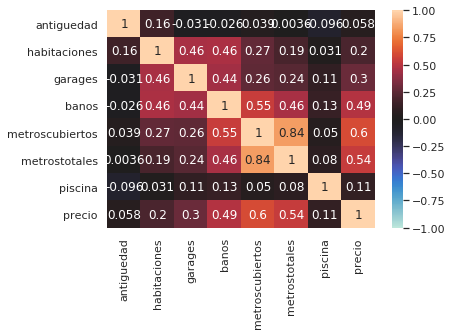

In [6]:
corr = df_original.corr()
sns.heatmap(corr, annot=True, center=0.0, vmin=-1.0, vmax=1.0)

## Muy mala correlación con antiguedad y piscina

Se podrían sacar estas dos columnas y ver que da

# Funciones utiles

In [7]:
def simple_regression(x_df, y):
    linear_regressor = LinearRegression()
    linear_regressor.fit(x_df, y)
    
    y_pred = linear_regressor.predict(x_df)
    
    assert(len(y) == len(y_pred))
    return (linear_regressor, y_pred)

def delete_negatives(y, y_pred):
    assert(len(y) == len(y_pred))
    y_out = []
    y_pred_out = []
    for y_i, y_pred_i in zip(y, y_pred):
        if y_pred_i >= 0:
            y_out.append(y_i)
            y_pred_out.append(y_pred_i)

    return y_out, y_pred_out

La funcion kfold toman n segmentos en el parametro, itera por cada uno y en cada uno de ellos hace kfold. Una vez eso calcula y guarda el regressor para cada kfold de cada segmento y lo guarda para poder ver coeficientes o usarlos luego. Calcula RMSE, RMLSE, MEA y accuracy por cada kfold y lo guarda. Tambien se guarda todas las predicciones y todas los y de cada kfold para luego calcular el error de todo el modelo para poder compararlos entre modelos distintos para ver cuales dan mejor que otros

In [8]:
def calc_errors(y_test, y_pred):
    rmse     = sqrt(mean_squared_error(y_test, y_pred))
    rmlse    = sqrt(mean_squared_log_error(y_test, y_pred))
    mae      = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, np.around(y_pred))
    return {'rmse':rmse, 'rmlse': rmlse, 'mae': mae, 'accuracy': accuracy}

def run_kfold(segmentos, y_label='precio'):
    out = {}
    global_y      = []
    global_y_pred = []
    for seg in segmentos.keys():
        data = segmentos[seg]
        
        y = data[y_label]
        x = data.drop([y_label], axis=1)
        
        results    = []
        runs       = []
        regressors = []

        kfold = KFold(10, shuffle=True, random_state=1)
        for train, test in kfold.split(data):
            X_train = x.values[train]
            y_train = y.values[train]

            X_test = x.values[test]
            y_test = y.values[test]

#             linear_regressor = LinearRegression().fit(X_train, y_train)
#             y_pred = linear_regressor.predict(X_test)
            linear_regressor = metnum.LinearRegression()
            linear_regressor.fit(X_train, y_train)
            y_pred = [y_p[0] for y_p in linear_regressor.predict(X_test)]
            
            
            y_test, y_pred = delete_negatives(y_test, y_pred)
            
            # actualizo y, y_pred global para calcular el rmse de forma global
            assert len(y_test) >= 1          , "Tienen que haber mas de 1 registro de test"
            assert len(y_test) == len(y_pred), "Tienen que tenes la misma cantidad y e y_pred"
            
            global_y      = global_y      + y_test
            global_y_pred = global_y_pred + y_pred

            results.append(calc_errors(y_test, y_pred))
            runs.append({'y_test': y_test, 'y_pred': y_pred})
            regressors.append(linear_regressor)
        
        out[seg] = {'results': pd.DataFrame(results), 'regressors': regressors, 'runs': runs}
    global_errors = calc_errors(global_y, global_y_pred)
    out['global_errors'] =  global_errors
    return out

# K-fold por segmentos

In [9]:
def run_kfold_show_info(segmentos, y_label='precio'):
    print("Segmentos:")
    for seg in segmentos.keys():
        print("{:15}: {:6} registros".format(seg, len(segmentos[seg].index)))
    
    r_kfold = run_kfold(segmentos, y_label)
    
    print()
    print()
    print("Error global")
    for k in r_kfold['global_errors'].keys():
        print("{:10} : {}".format(k, format(r_kfold['global_errors'][k], ".6E")))
    
    return r_kfold

## prediccion con kfold de todo el data set

#### tirar las predicciones con todo el dataset sin ningun segmento, para tener un error base

In [10]:
todo = {'todo': df_original.drop(['tipodepropiedad', 'provincia'], axis=1)}
results_todo = run_kfold(todo, 'banos')

In [11]:
results_todo['todo']['results'].mean()

rmse        0.659424
rmlse       0.208190
mae         0.509664
accuracy    0.592243
dtype: float64

In [12]:
print(todo['todo'].columns.drop(['banos']))
results_todo['todo']['regressors'][0].coefs()

Index(['antiguedad', 'habitaciones', 'garages', 'metroscubiertos',
       'metrostotales', 'piscina', 'precio'],
      dtype='object')


array([[-8.27087185e-03],
       [ 2.18184216e-01],
       [ 1.81644262e-01],
       [ 3.04759071e-03],
       [-2.46823257e-04],
       [ 1.79212832e-01],
       [ 8.09679671e-08],
       [ 5.29513468e-01]])

## Segmentacion por propiedades

Como esta en el notebook de "Analisis exploratoria" vamos a dividir en 4 grupos:
- Apartamentos
- Casas, Casas en condomivion, Casa uso de suelo (viviendas)
- Local Comercial, Oficina comercial, Bodega comercial, Terreno comercial, Local en centro comercial (comerciales)
- Otros (son todo el resto)


In [13]:
def segmentacion_propiedades(df):
    segmentos = {}
    
    departamentos = ["Apartamento"]
    segmentos["departamentos"] = df[df.tipodepropiedad.isin(departamentos)].drop(['tipodepropiedad', 'provincia'], axis=1)
    
    casas = ["Casa", "Casa en condominio", "Casa uso de suelo"]
    segmentos["casas"] = df[df.tipodepropiedad.isin(casas)].drop(['tipodepropiedad', 'provincia'], axis=1)
    
    comerciales = ["Local Comercial", "Oficina comercial", "Bodega comercial", "Terreno comercial", "Local en centro comercial"]
    segmentos["comerciales"] = df[df.tipodepropiedad.isin(comerciales)].drop(['tipodepropiedad', 'provincia'], axis=1)
    
    otros = departamentos + casas + comerciales
    segmentos['otros'] = df[~df.tipodepropiedad.isin(otros)].drop(['tipodepropiedad', 'provincia'], axis=1)

    return segmentos

#### prediccion con segmentos de propiedades pero sin ninguna feature nueva

Mejoran todas las métricas

In [14]:
segmentos_propiedades = segmentacion_propiedades(df_original)
kfold_propiedades = run_kfold_show_info(segmentos_propiedades, 'banos')

Segmentos:
departamentos  :  57341 registros
casas          : 161722 registros
comerciales    :   7693 registros
otros          :  13198 registros


Error global
rmse       : 6.404111E-01
rmlse      : 2.004399E-01
mae        : 4.929055E-01
accuracy   : 6.094418E-01


##  Segmentacion por provincias

Agarramos el top X provincias y juntamos el resto en un segmento llamado "todos"

In [15]:
def segmentacion_provincias(df, top_provinces=10):
    segmentos = {}
    
    provincias = list(df.groupby('provincia').count()['precio'].sort_values(ascending=False).head(top_provinces).index)
    
    for p in provincias:
        segmentos[p] = df[df.provincia == p].drop(['tipodepropiedad', 'provincia'], axis=1)
    
    segmentos['otros'] = df[~df.provincia.isin(provincias)].drop(['tipodepropiedad', 'provincia'], axis=1)

    return segmentos

se puede modificar la cantidad de provincias a tomar

In [16]:
segmentos_provincias = segmentacion_provincias(df_original, 20)

kfold_provincias = run_kfold_show_info(segmentos_provincias, 'banos')

Segmentos:
Distrito Federal:  58790 registros
Edo. de México :  41604 registros
Jalisco        :  21238 registros
Querétaro      :  16988 registros
Nuevo León     :  15324 registros
Puebla         :  10421 registros
San luis Potosí:   8411 registros
Yucatán        :   7925 registros
Morelos        :   7337 registros
Veracruz       :   5760 registros
Quintana Roo   :   4756 registros
Chihuahua      :   4590 registros
Coahuila       :   3695 registros
Baja California Norte:   3220 registros
Sonora         :   2988 registros
Guanajuato     :   2860 registros
Guerrero       :   2678 registros
Hidalgo        :   2521 registros
Michoacán      :   2471 registros
Tamaulipas     :   2303 registros
otros          :  14074 registros


Error global
rmse       : 6.448537E-01
rmlse      : 2.029352E-01
mae        : 4.970433E-01
accuracy   : 6.103029E-01


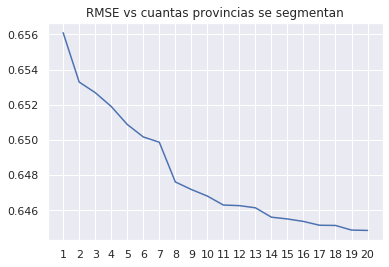

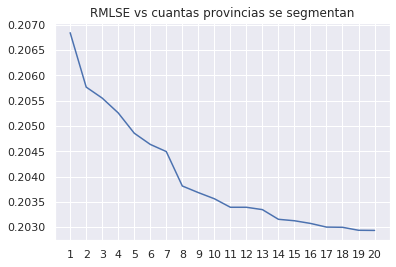

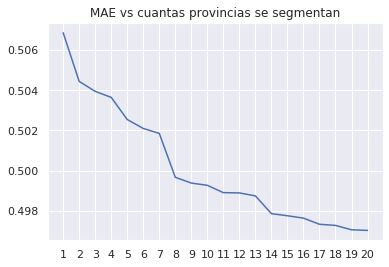

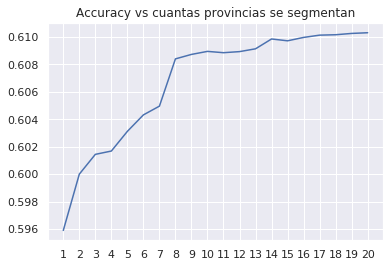

CPU times: user 23.4 s, sys: 49.4 ms, total: 23.4 s
Wall time: 23.4 s


In [17]:
%%time

max_provinces_segments=21
p_errors = {'rmse': [], 'rmlse': [], 'mae': [], 'accuracy': []}
for i in range(1, max_provinces_segments):
    segmento_i = segmentacion_provincias(df_original, i)
    kfold_p_i = run_kfold(segmento_i, 'banos')
    p_errors['rmse'] .append(kfold_p_i['global_errors']['rmse'])
    p_errors['rmlse'].append(kfold_p_i['global_errors']['rmlse'])
    p_errors['mae'] .append(kfold_p_i['global_errors']['mae'])
    p_errors['accuracy'] .append(kfold_p_i['global_errors']['accuracy'])
    

df_p = pd.DataFrame(data=p_errors, index=range(1, max_provinces_segments))
df_p.rmse.plot(title="RMSE vs cuantas provincias se segmentan")
_ = plt.xticks(range(1, max_provinces_segments))
plt.show()
df_p.rmlse.plot(title="RMLSE vs cuantas provincias se segmentan")
_ = plt.xticks(range(1, max_provinces_segments))
plt.show()
df_p.mae.plot(title="MAE vs cuantas provincias se segmentan")
_ = plt.xticks(range(1, max_provinces_segments))
plt.show()
df_p.accuracy.plot(title="Accuracy vs cuantas provincias se segmentan")
_ = plt.xticks(range(1, max_provinces_segments))
plt.show()

In [18]:
def correr_sin_segmentar_y_segmentando(df, y_label='banos'):
    todo = {'todo': df.drop(['tipodepropiedad', 'provincia'], axis=1)}
    kfold_todo = run_kfold(todo, y_label)
    
    segmentos_propiedades = segmentacion_propiedades(df)
    kfold_propiedades = run_kfold(segmentos_propiedades, y_label)
    
    segmentos_provincias = segmentacion_provincias(df, 17)
    kfold_provincias = run_kfold(segmentos_provincias, y_label)
    
    print("################")
    print("Sin segmentar")
    for k in kfold_todo['global_errors'].keys():
        print("{:10} : {}".format(k, format(kfold_todo['global_errors'][k], ".6E")))
    print("################")
    print("Segmentado por propiedades")
    for k in kfold_propiedades['global_errors'].keys():
        print("{:10} : {}".format(k, format(kfold_propiedades['global_errors'][k], ".6E")))
    print("################")
    print("Segmentado por provincias")
    for k in kfold_provincias['global_errors'].keys():
        print("{:10} : {}".format(k, format(kfold_provincias['global_errors'][k], ".6E")))
    print("################")
    
    return (todo, kfold_todo, segmentos_propiedades, kfold_propiedades, segmentos_provincias, kfold_provincias)

# Features engineering

Aquí vamos a analizar nuevos features y trataremos de mejorar los modelos de prediccion

In [19]:
# todo = {'todo': df_original.drop(['tipodepropiedad', 'provincia'], axis=1)}
# results_todo = run_kfold_show_info(todo)
run_todo = correr_sin_segmentar_y_segmentando(df_original, 'banos')

################
Sin segmentar
rmse       : 6.594291E-01
rmlse      : 2.081921E-01
mae        : 5.096639E-01
accuracy   : 5.922427E-01
################
Segmentado por propiedades
rmse       : 6.404111E-01
rmlse      : 2.004399E-01
mae        : 4.929055E-01
accuracy   : 6.094418E-01
################
Segmentado por provincias
rmse       : 6.451481E-01
rmlse      : 2.030010E-01
mae        : 4.973482E-01
accuracy   : 6.101278E-01
################


##### probe de sacar cualquier feature del dataset completo y todo hace que empeore... incluso saque metros totales que deberia estar compensado con metroscubiertos pero da peor el RSME

# feature ratio metros cubiertos / habitaciones

hay propiedades con 0 habitaciones, asique hacemos metroscubiertos/(habitaciones+1)

In [20]:
data_ratio = df_original.copy()
data_ratio['ratio'] = data_ratio.metroscubiertos / (data_ratio.habitaciones + 1)

In [21]:
run_ratio = correr_sin_segmentar_y_segmentando(data_ratio)

################
Sin segmentar
rmse       : 6.557514E-01
rmlse      : 2.061381E-01
mae        : 5.048280E-01
accuracy   : 6.044075E-01
################
Segmentado por propiedades
rmse       : 6.397954E-01
rmlse      : 2.000626E-01
mae        : 4.918234E-01
accuracy   : 6.115756E-01
################
Segmentado por provincias
rmse       : 6.424017E-01
rmlse      : 2.016523E-01
mae        : 4.929992E-01
accuracy   : 6.136910E-01
################


Mejora siempre un poquitin con cada segmentacion

# metroscubiertos / precio

In [22]:
data_ratio_precio = df_original.copy()
data_ratio_precio['ratio'] = data_ratio_precio.metroscubiertos / (data_ratio_precio.precio)

In [23]:
run_ratio_precio = correr_sin_segmentar_y_segmentando(data_ratio_precio)

################
Sin segmentar
rmse       : 6.516689E-01
rmlse      : 2.062032E-01
mae        : 5.034456E-01
accuracy   : 6.024856E-01
################
Segmentado por propiedades
rmse       : 6.321966E-01
rmlse      : 1.977598E-01
mae        : 4.854627E-01
accuracy   : 6.178527E-01
################
Segmentado por provincias
rmse       : 6.393300E-01
rmlse      : 2.019107E-01
mae        : 4.935096E-01
accuracy   : 6.123256E-01
################


## graficos

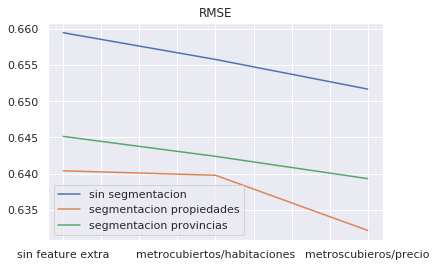

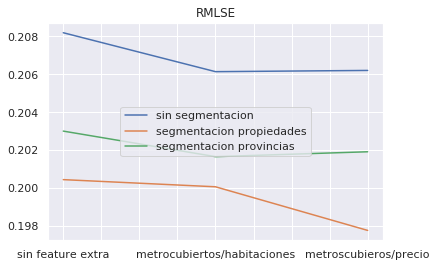

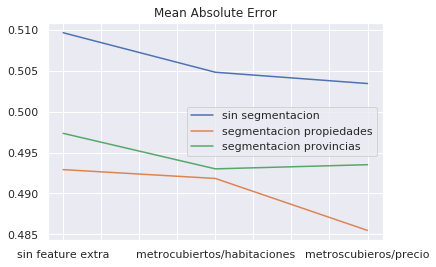

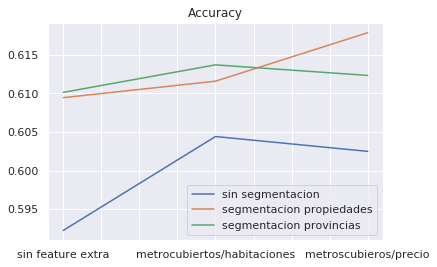

In [24]:
def agregar_dato(sin, seg_prop, seg_prov, indexes, metrica, run, index):
    sin.append(run[1]['global_errors'][metrica])
    seg_prop.append(run[3]['global_errors'][metrica])
    seg_prov.append(run[5]['global_errors'][metrica])
    indexes.append(index)


def plot(metrica, title):
    sin      = []
    seg_prop = []
    seg_prov = []
    indexes  = []
    agregar_dato(sin, seg_prop, seg_prov, indexes, metrica, run_todo, 'sin feature extra')
    agregar_dato(sin, seg_prop, seg_prov, indexes, metrica, run_ratio, 'metrocubiertos/habitaciones')
    agregar_dato(sin, seg_prop, seg_prov, indexes, metrica, run_ratio_precio, 'metroscubieros/precio')

    df_barplot = pd.DataFrame({'sin segmentacion': sin,
                               'segmentacion propiedades': seg_prop,
                               'segmentacion provincias': seg_prov,
                               }, index=indexes)

    df_barplot.plot(rot=0, figsize=(6, 4), title=title)
    

plot('rmse', 'RMSE')
plot('rmlse', 'RMLSE')
plot('mae', 'Mean Absolute Error')
plot('accuracy', 'Accuracy')